In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d abdallahwagih/spam-emails

Dataset URL: https://www.kaggle.com/datasets/abdallahwagih/spam-emails
License(s): apache-2.0
spam-emails.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/spam-emails.zip

Archive:  /content/spam-emails.zip
replace spam.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd

df = pd.read_csv('/content/spam.csv')
print(df.head())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)


(5572, 2)
(5157, 2)


In [ ]:
import pandas as pd
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Print the columns of the DataFrame to check for the correct column name
print(df.columns)

df['Message'] = df['Message'].apply(lambda x: x.lower())
df['Message'] = df['Message'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))

nltk.download('punkt')
from nltk.tokenize import word_tokenize

df['Message'] = df['Message'].apply(lambda x: word_tokenize(x))

stop_words = set(stopwords.words('english'))
df['Message'] = df['Message'].apply(lambda x: [word for word in x if word not in stop_words])

ps = PorterStemmer()
df['Message'] = df['Message'].apply(lambda x: [ps.stem(word) for word in x])

df['Message'] = df['Message'].apply(lambda x: ' '.join(x))
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Index(['Category', 'Message'], dtype='object')
  Category                                            Message
0      ham  go jurong point crazi avail bugi n great world...
1      ham                              ok lar joke wif u oni
2     spam  free entri 2 wkli comp win fa cup final tkt 21...
3      ham                u dun say earli hor u c alreadi say
4      ham          nah dont think goe usf live around though


In [ ]:

df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})
print(df.head())


   Category                                            Message
0         0  go jurong point crazi avail bugi n great world...
1         0                              ok lar joke wif u oni
2         1  free entri 2 wkli comp win fa cup final tkt 21...
3         0                u dun say earli hor u c alreadi say
4         0          nah dont think goe usf live around though


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.Category==0]
df_minority = df[df.Category==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
print(df_upsampled.Category.value_counts())


Category
0    4516
1    4516
Name: count, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_upsampled['Message'], df_upsampled['Category'], test_size=0.2, random_state=42
)

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)  # You can adjust the number of words
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_sequence_length = 100  # You can adjust this based on your data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 128, input_length=max_sequence_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),  # Add a dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print('Test accuracy:', accuracy)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.8141 - loss: 0.3609 - val_accuracy: 0.9896 - val_loss: 0.0431
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9956 - loss: 0.0265 - val_accuracy: 0.9945 - val_loss: 0.0254
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9986 - loss: 0.0109 - val_accuracy: 0.9945 - val_loss: 0.0241
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.9987 - loss: 0.0110 - val_accuracy: 0.9917 - val_loss: 0.0399
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.9989 - loss: 0.0091 - val_accuracy: 0.9938 - val_loss: 0.0247
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9985 - loss: 0.0101 - val_accuracy: 0.9965 - val_loss: 0.0194
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9983 - loss: 0.0092 - val_accuracy: 0.9958 - val_loss: 0.0178
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9991 - loss: 0.0056 - 

In [ ]:
# Display new class counts
print(df_upsampled.Category.value_counts())

Category
0    4516
1    4516
Name: count, dtype: int64


In [ ]:
from sklearn.metrics import classification_report

y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       902
           1       0.99      1.00      1.00       905

    accuracy                           1.00      1807
   macro avg       1.00      1.00      1.00      1807
weighted avg       1.00      1.00      1.00      1807



Epoch 1/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9965 - val_loss: 0.0291
Epoch 2/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9986 - loss: 0.0062 - val_accuracy: 0.9958 - val_loss: 0.0422
Epoch 3/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9988 - loss: 0.0053 - val_accuracy: 0.9958 - val_loss: 0.0432
Epoch 4/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9958 - val_loss: 0.0504
Epoch 5/5
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9993 - loss: 0.0046 - val_accuracy: 0.9958 - val_loss: 0.0444


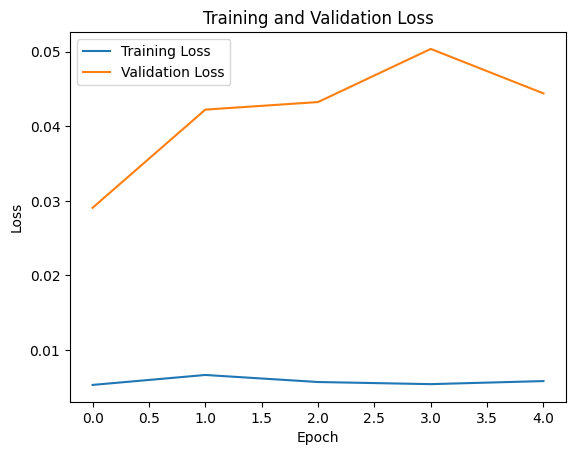

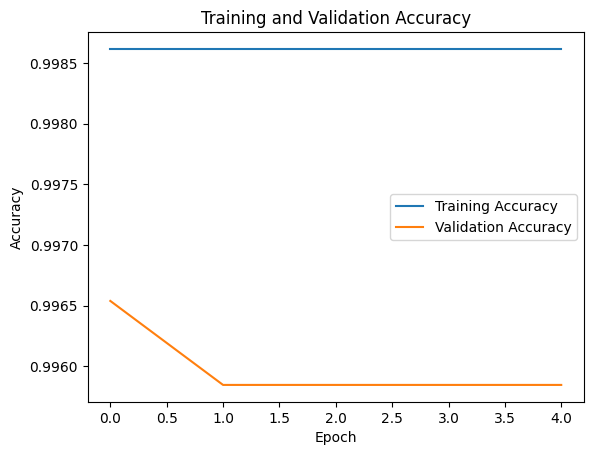

In [ ]:
import matplotlib.pyplot as plt

# Train the model and store the history
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Extract the training and validation loss and accuracy from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()